In [2]:
from src.operators import *
from src.diagram import *
from src.quarks import *
from src.wick_utilities import *
from src.wick_contract import *

In [3]:
c0=Epsilon_Tensor(['c0','c1','c2','c3'])
c1=Spin_Matrix('X1',['s0','s1'])
c2=Spin_Matrix('X2',['s2','s3'])
                  
q0=Quark(False,'u','s0','c0','tf')
q1=Quark(False,'u','s1','c1','tf')
q2=Quark(False,'d','s2','c2','tf')
q3=Quark(False,'d','s3','c3','tf')

c3=Epsilon_Tensor(['c4','c5','c6','c7'])  
c4=Spin_Matrix('X3',['s4','s5'])
c5=Spin_Matrix('X4',['s6','s7'])

q4=Quark(False,'u','s4','c4','tf')
q5=Quark(False,'u','s5','c5','tf')
q6=Quark(False,'d','s6','c6','tf')
q7=Quark(False,'d','s7','c7','tf')

annihilate_baryon = Operator(1,[c0,c1,c2],[q0,q1,q2,q3])
annihilate_two_baryons = Operator(1,[c0,c1,c2,c3,c4,c5],[q0,q1,q2,q3,q4,q5,q6,q7])



c6=Epsilon_Tensor(['c8','c9','c10','c11'])
c7=Spin_Matrix('X5',['s8','s9'])
c8=Spin_Matrix('X6',['s10','s11'])

q6=Quark(True,'u','s8','c8','ti')
q7=Quark(True,'u','s9','c9','ti')
q8=Quark(True,'d','s10','c10','ti')
q9=Quark(True,'d','s11','c11','ti')

c9=Epsilon_Tensor(['c12','c13','c14','c15'])
c10=Spin_Matrix('X7',['s12','s13'])
c11=Spin_Matrix('X8',['s14','s15'])

q10=Quark(True,'u','s12','c12','ti')
q11=Quark(True,'u','s13','c13','ti')
q12=Quark(True,'d','s14','c14','ti')
q13=Quark(True,'d','s15','c15','ti')

create_baryon = Operator(1,[c6,c7,c8],[q6,q7,q8,q9])
create_two_baryons = Operator(1,[c6,c7,c8,c9,c10,c11],[q6,q7,q8,q9,q10,q11,q12,q13])


res = contract(annihilate_baryon, create_baryon)
res2 = contract(annihilate_two_baryons, create_two_baryons)

for d in res:
    d.laphify()

for d in res2:
    d.laphify()

In [4]:
import copy

def get_first_epsilon_idx_ends(diag):
    for elem in diag.ci:
        if(elem.name=='eps'):
            idx_ends=[]
            for idx in elem.indices:
                idx_ends.append(idx[1:])
            return idx_ends
    
    return []
        
#print(get_first_epsilon_idx_ends(tst))

def create_baryon_block(diag):
    while get_first_epsilon_idx_ends(diag)!=[]:
        idx_ends = get_first_epsilon_idx_ends(diag)
        #print(idx_ends)
        #to_remove = []
        time='?'
        for elem in diag.ci[:]:
            #print(elem)
            for idx in elem.indices:
                #print(idx[1:])
                if idx[1:] in idx_ends:
                    if(elem.name=='V'):
                        time = elem.indices[2]
                    if(elem.name!='B'):
                        diag.ci.remove(elem)
                    break
        
        diag.ci.append(Indexed_Object('B',idx_ends + [time]))
    return diag

def short_props(diag):
    new_props = []
    for prop in diag.props:
        new_props.append(Short_Prop(prop.name,
                                    prop.left_indices.c[1:],prop.right_indices.c[1:],
                                    prop.left_indices.t,prop.right_indices.t))
    diag.props = new_props
    return diag
        
        
#for d in res:
#   short_props(create_baryon_block(d))

def create_baryon_source(diag):
    for b in diag.ci:    
        if b.indices[-1]=='tf':
            for i,contract_idx in enumerate(b.indices[:-1]):
                for prop in diag.props:
                    if(contract_idx==prop.l):
                        b.indices[i]=prop.r
                        diag.props.remove(prop)
                        break
                        
            b.indices = b.indices + ['ti']
    return diag
            

In [5]:
tst=copy.deepcopy(res)
for d in tst:
    d=short_props(create_baryon_block(d))

In [6]:
for d in tst:
    print(create_baryon_source(d))

1 B_{891011tfti}B_{891011ti}
-1 B_{981011tfti}B_{891011ti}
1 B_{981110tfti}B_{891011ti}
-1 B_{891110tfti}B_{891011ti}


In [14]:
#brute force counting.
costs = {}
for d in tst:
    nested_sums = 0
    for idx in d.ci[0].indices[0:4]:
        if(idx in d.ci[1].indices):
            nested_sums+=1
    if nested_sums in costs:
        costs[nested_sums]+=1
    else:
        costs[nested_sums]=1
print('total loops:')
for k,v in costs.items():
    print('  {}*N^{}'.format(v,k))

total loops:
  4*N^4


In [16]:
for d in tst:
    contractions = []
    for i,idx in enumerate(d.ci[0].indices[0:4]):
        j=d.ci[1].indices.index(idx)
        contractions.append([i,j])
    print(contractions)

[[0, 0], [1, 1], [2, 2], [3, 3]]
[[0, 1], [1, 0], [2, 2], [3, 3]]
[[0, 1], [1, 0], [2, 3], [3, 2]]
[[0, 0], [1, 1], [2, 3], [3, 2]]


1 B_{891011tfti}B_{891011ti}
-1 B_{981011tfti}B_{891011ti}
1 B_{981110tfti}B_{891011ti}
-1 B_{891110tfti}B_{891011ti}


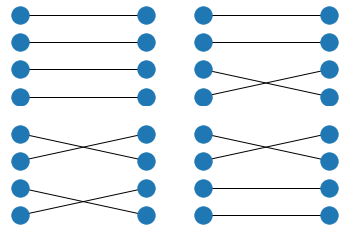

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

tst=copy.deepcopy(res)
for d in tst:
    d=short_props(create_baryon_block(d))

for d in tst:
    print(create_baryon_source(d))
    
G = nx.Graph()
G.add_node('8ti',pos=(1,1))
G.add_node('9ti',pos=(1,2))
G.add_node('10ti',pos=(1,3))
G.add_node('11ti',pos=(1,4))
G.add_node('8tf',pos=(5,1))
G.add_node('9tf',pos=(5,2))
G.add_node('10tf',pos=(5,3))
G.add_node('11tf',pos=(5,4))
pos=nx.get_node_attributes(G,'pos')

xdim = int(len(tst)/2)
ydim = int(len(tst)-len(tst)/2)
for iplt,d in enumerate(tst):
    Gtmp=G.copy()
    pos=nx.get_node_attributes(G,'pos')

    for i,idx in enumerate(d.ci[0].indices[0:4]):
        Gtmp.add_edge(idx+d.ci[0].indices[4],
                   d.ci[1].indices[i]+tst[0].ci[0].indices[5])
    plt.subplot(xdim,ydim,iplt+1)
    nx.draw(Gtmp,pos)
plt.savefig('baryon_correlator.png')

576
subplot lens are xdim=6, ydim=6


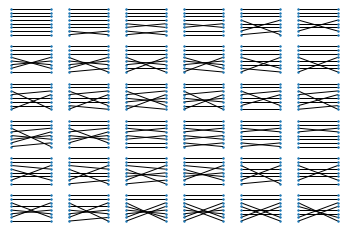

In [44]:
tst=copy.deepcopy(res2)
for d in tst:
    d=short_props(create_baryon_block(d))
    
for d in tst:
    create_baryon_source(d)

fulltst=copy.deepcopy(tst)
print(len(tst))

G = nx.Graph()
for i in range(8,16):
    G.add_node(str(i)+'ti',pos=(1,i-8+1))
    G.add_node(str(i)+'tf',pos=(15,i-8+1))
pos=nx.get_node_attributes(G,'pos')

tst=tst[0:int(len(tst)/16)]
    
import math

xdim = int(math.sqrt(len(tst)))
ydim = 0
if(xdim*xdim == len(tst)):
    ydim = xdim
else:
    ydim = xdim+1
if(xdim*ydim<len(tst)):
    xdim+=1
print('subplot lens are xdim={}, ydim={}'.format(xdim,ydim))
for iplt,d in enumerate(tst):
    Gtmp=G.copy()
    pos=nx.get_node_attributes(G,'pos')

    for i,idx in enumerate(d.ci[0].indices[0:4]):
        Gtmp.add_edge(idx+d.ci[0].indices[4],
                   d.ci[3].indices[i]+tst[0].ci[0].indices[5])
    for i,idx in enumerate(d.ci[2].indices[0:4]):
        Gtmp.add_edge(idx+d.ci[2].indices[4],
                   d.ci[1].indices[i]+tst[0].ci[2].indices[5])
    
    
    
    plt.subplot(xdim,ydim,iplt+1)
    nx.draw(Gtmp,pos,node_size=2)
plt.savefig('bb_correlator.png')

In [45]:
print(tst[0])
print(tst[13])

1 B_{891011tfti}B_{12131415ti}B_{12131415tfti}B_{891011ti}
-1 B_{1281011tfti}B_{12131415ti}B_{1391415tfti}B_{891011ti}


In [48]:
diagrams = []
for d in fulltst:
    contractions = {}
    for i,idx in enumerate(d.ci[0].indices[0:4]):
        if(idx in d.ci[1].indices):
            j=d.ci[1].indices.index(idx)
            if('01' in contractions):
                contractions['01'].append([i,j])
            else:
                contractions['01']=[[i,j]]
        elif(idx in d.ci[3].indices):
            j=d.ci[3].indices.index(idx)
            if('03' in contractions):
                contractions['03'].append([i,j])
            else:
                contractions['03']=[[i,j]]
    for i,idx in enumerate(d.ci[2].indices[0:4]):
        if(idx in d.ci[1].indices):
            j=d.ci[1].indices.index(idx)
            if('21' in contractions):
                contractions['21'].append([i,j])
            else:
                contractions['21']=[[i,j]]
        elif(idx in d.ci[3].indices):
            j=d.ci[3].indices.index(idx)
            if('23' in contractions):
                contractions['23'].append([i,j])
            else:
                contractions['23']=[[i,j]]
    diagrams.append(contractions)
    #print(contractions)

In [70]:
codeStr=''
for i,contractions in enumerate(diagrams):
    codeStr+='auto graph{} = Graph({{\n'.format(i)
    for baryons,indices in contractions.items():
        codeStr+='{{{{{},{}}},{{'.format(baryons[0],baryons[1])
        for pair in indices:
            codeStr+='{{{},{}}},'.format(pair[0],pair[1])
        codeStr=codeStr[:-1]
        codeStr+='}},'
    codeStr=codeStr[:-1]
    codeStr+='});'
    
    codeStr+='\n'
print(codeStr)

auto graph0 = Graph({
{{0,3},{{0,0},{1,1},{2,2},{3,3}}},{{2,1},{{0,0},{1,1},{2,2},{3,3}}}});
auto graph1 = Graph({
{{0,3},{{0,1},{1,0},{2,2},{3,3}}},{{2,1},{{0,0},{1,1},{2,2},{3,3}}}});
auto graph2 = Graph({
{{0,3},{{0,1},{1,0},{2,3},{3,2}}},{{2,1},{{0,0},{1,1},{2,2},{3,3}}}});
auto graph3 = Graph({
{{0,3},{{0,0},{1,1},{2,3},{3,2}}},{{2,1},{{0,0},{1,1},{2,2},{3,3}}}});
auto graph4 = Graph({
{{0,3},{{0,1},{2,2},{3,3}}},{{0,1},{{1,0}}},{{2,3},{{0,0}}},{{2,1},{{1,1},{2,2},{3,3}}}});
auto graph5 = Graph({
{{0,3},{{0,0},{2,2},{3,3}}},{{0,1},{{1,0}}},{{2,3},{{0,1}}},{{2,1},{{1,1},{2,2},{3,3}}}});
auto graph6 = Graph({
{{0,3},{{0,0},{2,3},{3,2}}},{{0,1},{{1,0}}},{{2,3},{{0,1}}},{{2,1},{{1,1},{2,2},{3,3}}}});
auto graph7 = Graph({
{{0,3},{{0,1},{2,3},{3,2}}},{{0,1},{{1,0}}},{{2,3},{{0,0}}},{{2,1},{{1,1},{2,2},{3,3}}}});
auto graph8 = Graph({
{{0,1},{{0,0}}},{{0,3},{{1,1},{2,3},{3,2}}},{{2,3},{{0,0}}},{{2,1},{{1,1},{2,2},{3,3}}}});
auto graph9 = Graph({
{{0,1},{{0,0}}},{{0,3},{{1,0},{2,3},{3,2}

In [71]:
diagStr=''
for i,contraction in enumerate(diagrams):
    diagStr+='diagList.push_back(Diagram(graph{},{{0,1,2,3}}));\n'.format(i)
print(diagStr)

diagList.push_back(Diagram(graph0,{0,1,2,3}));
diagList.push_back(Diagram(graph1,{0,1,2,3}));
diagList.push_back(Diagram(graph2,{0,1,2,3}));
diagList.push_back(Diagram(graph3,{0,1,2,3}));
diagList.push_back(Diagram(graph4,{0,1,2,3}));
diagList.push_back(Diagram(graph5,{0,1,2,3}));
diagList.push_back(Diagram(graph6,{0,1,2,3}));
diagList.push_back(Diagram(graph7,{0,1,2,3}));
diagList.push_back(Diagram(graph8,{0,1,2,3}));
diagList.push_back(Diagram(graph9,{0,1,2,3}));
diagList.push_back(Diagram(graph10,{0,1,2,3}));
diagList.push_back(Diagram(graph11,{0,1,2,3}));
diagList.push_back(Diagram(graph12,{0,1,2,3}));
diagList.push_back(Diagram(graph13,{0,1,2,3}));
diagList.push_back(Diagram(graph14,{0,1,2,3}));
diagList.push_back(Diagram(graph15,{0,1,2,3}));
diagList.push_back(Diagram(graph16,{0,1,2,3}));
diagList.push_back(Diagram(graph17,{0,1,2,3}));
diagList.push_back(Diagram(graph18,{0,1,2,3}));
diagList.push_back(Diagram(graph19,{0,1,2,3}));
diagList.push_back(Diagram(graph20,{0,1,2,3}));
di

In [76]:
n=12

256*(12**2) + 304*(12**4)

3170304.0